<a href="https://colab.research.google.com/github/onnnnn/INTRODUCTION-AND-PRACTICUM-OF-DEEP-LEARNING-IN-MACHINE-LEARNING/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import packages & set up

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
!pip install fancyimpute
from fancyimpute import KNN, SoftImpute, IterativeImputer
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

from keras.utils.vis_utils import plot_model

In [2]:
FILE_PATH = f'{os.getcwd()}/drive/MyDrive/機器與深度學習導論與實務/projects/'
FILE_PATH

'/content/drive/MyDrive/機器與深度學習導論與實務/projects/'

# 0st
- without standardization
- without impute income
- without onehot (drop categorial features)
- include income's outlier

In [3]:
df0 = pd.read_csv(FILE_PATH + 'marketing_campaign.csv', delimiter='\t')
df0.dropna(inplace=True)
print('before drop:', df0.shape)
df = df0.drop(['Education', 'Marital_Status', 'ID', 'Year_Birth', 'Dt_Customer', 
               'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
               'MntSweetProducts', 'MntGoldProds', 'Z_CostContact', 'Z_Revenue'], axis=1)
print('after drop:', df.shape)
df.columns

before drop: (2216, 29)
after drop: (2216, 16)


Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')

In [4]:
X = df
Y = df0.MntWines.copy()
Y[Y < Y.quantile(0.65)] = 0
Y[Y > Y.quantile(0.65)] = 1

print(Counter(Y))
assert len(Y.unique()) == 2
assert len(X) == len(Y)
Y_boost = Y
Y = np_utils.to_categorical(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Counter({0: 1440, 1: 776})


## DNN

In [5]:
number_of_features = x_train.shape[1]
number_of_labels = y_train.shape[1]

METRICS = [
    'accuracy', 
    metrics.Precision(name='precision', thresholds=0.5), 
    tf.keras.metrics.Recall(), 
    tfa.metrics.F1Score(num_classes=2, threshold=0.5)
    ]

early_stopping = EarlyStopping(
    monitor='precision', 
    min_delta=0.01, 
    patience=50, 
    verbose=1, 
    mode='max')

network = Sequential()
network.add(Dense(units=number_of_features, activation='relu', input_dim=number_of_features))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu')) #kernel_regularizer=l2(0.01)
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=number_of_labels, activation='sigmoid'))

network.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    optimizer='adam', 
    metrics=METRICS)

print('training...')
history = network.fit(x_train, 
                      y_train, 
                      epochs=1000, 
                      batch_size = 50,
                      verbose=0, 
                      validation_data=(x_test, y_test), 
                      callbacks=[early_stopping])

network_result_train = network.evaluate(x_train, y_train)
network_result_test = network.evaluate(x_test, y_test)

training...
Epoch 00077: early stopping
18/18 [==============================] - 0s 2ms/step - loss: 0.4091 - accuracy: 0.8484 - precision: 1.0000 - recall: 0.0090 - f1_score: 0.0140        


In [6]:
#print(network.summary())
#plot_model(network)


on training data:
    loss : 0.44740092754364014
    accuracy : 0.828519880771637
    precision : 1.0
    recall : 0.010830325074493885
    f1_score : [0.03257919 0.        ]

on test data:
    loss : 0.4091213643550873
    accuracy : 0.8483754396438599
    precision : 1.0
    recall : 0.009025271050632
    f1_score : [0.02793296 0.        ]




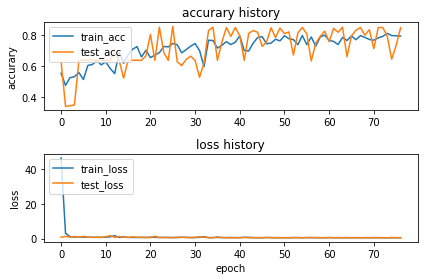

In [7]:
print('\non training data:')
for name, value in zip(network.metrics_names, network_result_train):
    print(' '*3, name, ':', value)

print('\non test data:')
for name, value in zip(network.metrics_names, network_result_test):
    print(' '*3, name, ':', value)

print('\n')

# training & testing accuracy
plt.subplot(211)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("accurary")
plt.title("accurary history")
plt.legend(['train_acc','test_acc'], loc='upper left')

# training & testing loss
plt.subplot(212)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.title("loss history")
plt.legend(['train_loss', 'test_loss'], loc='upper left')
plt.xlabel("epoch")

plt.tight_layout()
plt.show()

## XGBoost

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_boost, test_size=0.25, random_state=42)
print(len(x_train), len(x_test))
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)

print('XGBoost')
print('on training data:')
pred = xgbc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = xgbc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

1662 554
XGBoost
on training data:
   accuracy: 0.9205776173285198
   precision: 0.8301043219076006
   recall: 0.9686956521739131
   f1-score: 0.8940609951845907

on test data:
   accuracy: 0.8953068592057761
   precision: 0.8356807511737089
   recall: 0.8855721393034826
   f1-score: 0.859903381642512


## CatBoost

In [9]:
cbc = CatBoostClassifier()
cbc.fit(x_train, y_train)

Learning rate set to 0.012798
0:	learn: 0.6722083	total: 48.6ms	remaining: 48.5s
1:	learn: 0.6577743	total: 50.8ms	remaining: 25.4s
2:	learn: 0.6403857	total: 53.1ms	remaining: 17.6s
3:	learn: 0.6225048	total: 55.5ms	remaining: 13.8s
4:	learn: 0.6054723	total: 57.9ms	remaining: 11.5s
5:	learn: 0.5884791	total: 60.5ms	remaining: 10s
6:	learn: 0.5748884	total: 62.1ms	remaining: 8.81s
7:	learn: 0.5662392	total: 63ms	remaining: 7.82s
8:	learn: 0.5526674	total: 64.6ms	remaining: 7.11s
9:	learn: 0.5412304	total: 66.1ms	remaining: 6.55s
10:	learn: 0.5310533	total: 67.7ms	remaining: 6.09s
11:	learn: 0.5187947	total: 69.3ms	remaining: 5.71s
12:	learn: 0.5058874	total: 71ms	remaining: 5.39s
13:	learn: 0.4985199	total: 72.7ms	remaining: 5.12s
14:	learn: 0.4870450	total: 74.2ms	remaining: 4.87s
15:	learn: 0.4778438	total: 75.8ms	remaining: 4.66s
16:	learn: 0.4690731	total: 77.6ms	remaining: 4.49s
17:	learn: 0.4602833	total: 79.2ms	remaining: 4.32s
18:	learn: 0.4531554	total: 80.8ms	remaining: 4.17

In [10]:
print('CatBoost')
print('on training data:')
pred = cbc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = cbc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

CatBoost
on training data:
   accuracy: 0.9825511432009627
   precision: 0.9611486486486487
   recall: 0.9895652173913043
   f1-score: 0.9751499571550986

on test data:
   accuracy: 0.9043321299638989
   precision: 0.8627450980392157
   recall: 0.8756218905472637
   f1-score: 0.8691358024691358


## KNN

100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


Text(0, 0.5, 'Mean Error')

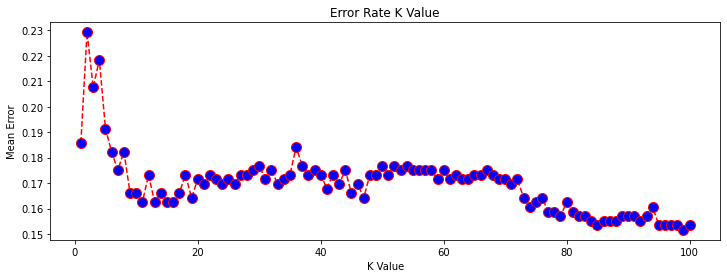

In [11]:
range_to = 101
error = []
for i in tqdm(range(1, range_to)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 4))
plt.plot(range(1, range_to), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [12]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train, y_train)

print('KNN')
print('on training data:')
pred = knn.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = knn.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

KNN
on training data:
   accuracy: 0.8321299638989169
   precision: 0.725609756097561
   recall: 0.8278260869565217
   f1-score: 0.7733549959382616

on test data:
   accuracy: 0.8285198555956679
   precision: 0.7476635514018691
   recall: 0.7960199004975125
   f1-score: 0.7710843373493975


## DecisionTree

Income:       0.0313
NumWebPurchases: 0.076
NumCatalogPurchases: 0.7187
NumStorePurchases: 0.1058
NumWebVisitsMonth: 0.0488
AcceptedCmp5: 0.0194


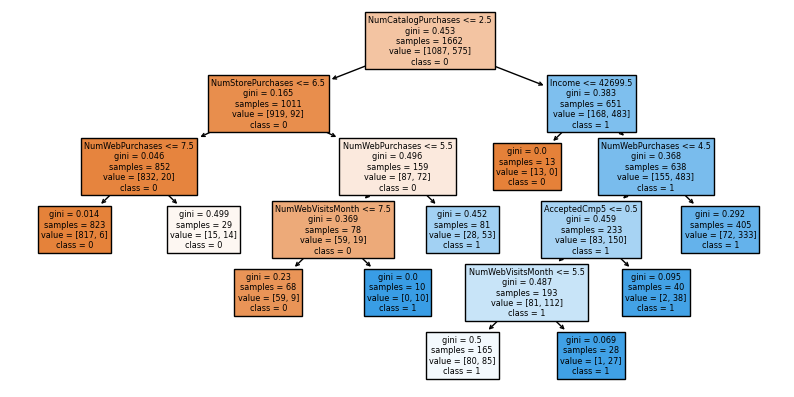

In [13]:
dtc = DecisionTreeClassifier(criterion = "gini", max_depth=10, 
                             min_samples_split=50, min_samples_leaf=5, 
                             max_leaf_nodes=10, random_state=48)
feature_names = df.columns.tolist()
dtc.fit(x_train, y_train)
for i, j in zip(feature_names, dtc.feature_importances_):
    if j > 0: print((i + ":").ljust(13), round(j, 4))

plt.figure(figsize = (10, 5), dpi = 100)
plot_tree(dtc, feature_names=feature_names, class_names=['0','1'], filled=True)
plt.show()

In [14]:
print('Decision Tree')
print('on training data:')
pred = dtc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = dtc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

Decision Tree
on training data:
   accuracy: 0.8724428399518652
   precision: 0.7489711934156379
   recall: 0.9495652173913044
   f1-score: 0.8374233128834356

on test data:
   accuracy: 0.8790613718411552
   precision: 0.7658730158730159
   recall: 0.9601990049751243
   f1-score: 0.8520971302428256


## RandomForest

In [15]:
clf = RandomForestClassifier(random_state = 6)
clf.fit(x_train, y_train)

print('Random Forest')
print('on training data:')
pred = clf.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = clf.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

Random Forest
on training data:
   accuracy: 1.0
   precision: 1.0
   recall: 1.0
   f1-score: 1.0

on test data:
   accuracy: 0.9025270758122743
   precision: 0.8656716417910447
   recall: 0.8656716417910447
   f1-score: 0.8656716417910447


## SVM

In [16]:
svm = SVC()
svm.fit(x_train, y_train)

print('SVM')
print('on training data:')
pred = svm.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = svm.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

SVM
on training data:
   accuracy: 0.8351383874849578
   precision: 0.7249626307922272
   recall: 0.8434782608695652
   f1-score: 0.7797427652733119

on test data:
   accuracy: 0.851985559566787
   precision: 0.771689497716895
   recall: 0.8407960199004975
   f1-score: 0.8047619047619048


# 1st
- income imputed with mean
- include income's outlier

In [17]:
df0 = pd.read_csv(FILE_PATH + 'marketing_campaign.csv', delimiter='\t')
df0['Age'] = 2022 - df0.Year_Birth
df0['Customer_Years'] = [2022 - int(df0.Dt_Customer[i].split('-')[2]) for i in range(df0.shape[0])]
df0.Income.fillna(df0.Income.mean(), inplace=True)
df = df0.drop(['ID', 'Year_Birth', 'Dt_Customer', 'MntWines', 'MntFruits', 
                'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
                'MntGoldProds', 'Z_CostContact', 'Z_Revenue'], axis=1)
df = pd.get_dummies(df)

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(df)
Y = df0.MntWines.copy()
Y[Y < Y.quantile(0.65)] = 0
Y[Y > Y.quantile(0.65)] = 1

print(Counter(Y))
assert len(Y.unique()) == 2
assert len(X) == len(Y)
Y_boost = Y
Y = np_utils.to_categorical(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Counter({0: 1456, 1: 784})


## DNN

In [19]:
number_of_features = x_train.shape[1]
number_of_labels = y_train.shape[1]

METRICS = [
    'accuracy', 
    metrics.Precision(name='precision', thresholds=0.5), 
    tf.keras.metrics.Recall(), 
    tfa.metrics.F1Score(num_classes=2, threshold=0.5)
    ]

early_stopping = EarlyStopping(
    monitor='precision', 
    min_delta=0.01, 
    patience=50, 
    verbose=1, 
    mode='max')

network = Sequential()
network.add(Dense(units=number_of_features, activation='relu', input_dim=number_of_features))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu')) #kernel_regularizer=l2(0.01)
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=number_of_labels, activation='sigmoid'))

network.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    optimizer='adam', 
    metrics=METRICS)

print('training...')
history = network.fit(x_train, 
                      y_train, 
                      epochs=1000, 
                      batch_size = 50,
                      verbose=0, 
                      validation_data=(x_test, y_test), 
                      callbacks=[early_stopping])

network_result_train = network.evaluate(x_train, y_train)
network_result_test = network.evaluate(x_test, y_test)

training...
Epoch 00111: early stopping
18/18 [==============================] - 0s 2ms/step - loss: 0.8012 - accuracy: 0.8786 - precision: 0.8832 - recall_1: 0.8643 - f1_score: 0.8663



on training data:
    loss : 0.018253689631819725
    accuracy : 0.9964285492897034
    precision : 0.9970184564590454
    recall_1 : 0.9952380657196045
    f1_score : [0.99640286 0.995587  ]

on test data:
    loss : 0.8011957406997681
    accuracy : 0.8785714507102966
    precision : 0.8832116723060608
    recall_1 : 0.8642857074737549
    f1_score : [0.8976608 0.8349057]




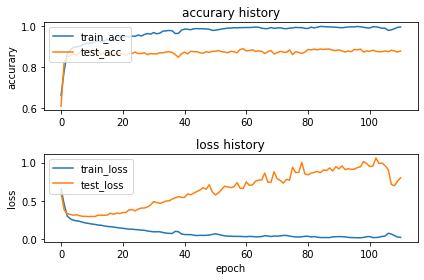

In [20]:
print('\non training data:')
for name, value in zip(network.metrics_names, network_result_train):
    print(' '*3, name, ':', value)

print('\non test data:')
for name, value in zip(network.metrics_names, network_result_test):
    print(' '*3, name, ':', value)

print('\n')

# training & testing accuracy
plt.subplot(211)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("accurary")
plt.title("accurary history")
plt.legend(['train_acc','test_acc'], loc='upper left')

# training & testing loss
plt.subplot(212)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.title("loss history")
plt.legend(['train_loss', 'test_loss'], loc='upper left')
plt.xlabel("epoch")

plt.tight_layout()
plt.show()

## XGBoost

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_boost, test_size=0.25, random_state=42)
print(len(x_train), len(x_test))
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)

print('XGBoost')
print('on training data:')
pred = xgbc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = xgbc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

1680 560
XGBoost
on training data:
   accuracy: 0.9315476190476191
   precision: 0.8594249201277955
   recall: 0.952212389380531
   f1-score: 0.9034424853064651

on test data:
   accuracy: 0.8946428571428572
   precision: 0.8508771929824561
   recall: 0.8858447488584474
   f1-score: 0.8680089485458612


## CatBoost

In [22]:
cbc = CatBoostClassifier()
cbc.fit(x_train, y_train)

Learning rate set to 0.012857
0:	learn: 0.6762262	total: 1.67ms	remaining: 1.67s
1:	learn: 0.6621313	total: 3.51ms	remaining: 1.75s
2:	learn: 0.6428354	total: 5.18ms	remaining: 1.72s
3:	learn: 0.6298578	total: 8.03ms	remaining: 2s
4:	learn: 0.6168024	total: 9.57ms	remaining: 1.9s
5:	learn: 0.6020155	total: 11ms	remaining: 1.83s
6:	learn: 0.5917402	total: 12.5ms	remaining: 1.77s
7:	learn: 0.5823809	total: 14ms	remaining: 1.73s
8:	learn: 0.5691034	total: 15.6ms	remaining: 1.72s
9:	learn: 0.5572095	total: 17.3ms	remaining: 1.72s
10:	learn: 0.5448248	total: 19ms	remaining: 1.71s
11:	learn: 0.5308852	total: 20.7ms	remaining: 1.7s
12:	learn: 0.5193560	total: 22.3ms	remaining: 1.7s
13:	learn: 0.5093454	total: 24ms	remaining: 1.69s
14:	learn: 0.5024050	total: 25.7ms	remaining: 1.69s
15:	learn: 0.4935609	total: 27.4ms	remaining: 1.69s
16:	learn: 0.4821673	total: 29.1ms	remaining: 1.68s
17:	learn: 0.4761792	total: 30.8ms	remaining: 1.68s
18:	learn: 0.4651307	total: 32.5ms	remaining: 1.68s
19:	le

In [23]:
print('CatBoost')
print('on training data:')
pred = cbc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = cbc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

CatBoost
on training data:
   accuracy: 0.9886904761904762
   precision: 0.972318339100346
   recall: 0.9946902654867257
   f1-score: 0.9833770778652668

on test data:
   accuracy: 0.9035714285714286
   precision: 0.8733031674208145
   recall: 0.8812785388127854
   f1-score: 0.8772727272727272


## KNN

100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


Text(0, 0.5, 'Mean Error')

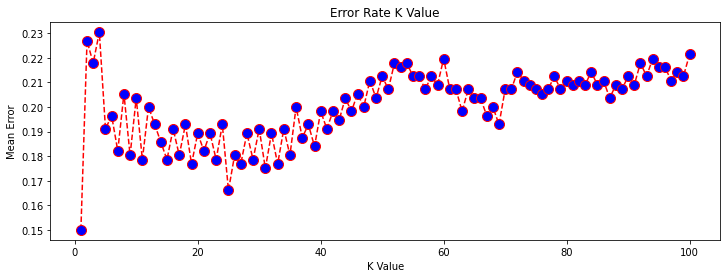

In [24]:
range_to = 101
error = []
for i in tqdm(range(1, range_to)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 4))
plt.plot(range(1, range_to), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [25]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train, y_train)

print('KNN')
print('on training data:')
pred = knn.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = knn.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

KNN
on training data:
   accuracy: 0.8690476190476191
   precision: 0.8484848484848485
   recall: 0.7433628318584071
   f1-score: 0.7924528301886794

on test data:
   accuracy: 0.8339285714285715
   precision: 0.8662790697674418
   recall: 0.680365296803653
   f1-score: 0.7621483375959078


## DecisionTree

Income:       0.049
NumWebPurchases: 0.0438
NumCatalogPurchases: 0.7505
NumStorePurchases: 0.119
NumWebVisitsMonth: 0.017
AcceptedCmp4: 0.0206


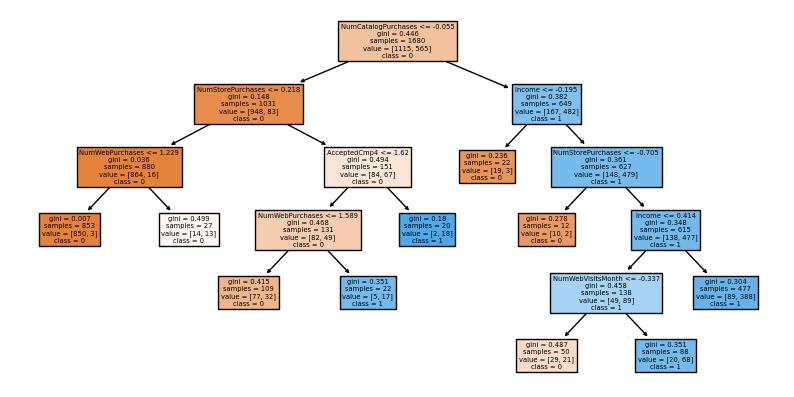

In [26]:
dtc = DecisionTreeClassifier(criterion = "gini", max_depth=10, 
                             min_samples_split=50, min_samples_leaf=5, 
                             max_leaf_nodes=10, random_state=48)
feature_names = df.columns.tolist()
dtc.fit(x_train, y_train)
for i, j in zip(feature_names, dtc.feature_importances_):
    if j > 0: print((i + ":").ljust(13), round(j, 4))

plt.figure(figsize = (10, 5), dpi = 100)
plot_tree(dtc, feature_names=feature_names, class_names=['0','1'], filled=True)
plt.show()

In [27]:
print('Decision Tree')
print('on training data:')
pred = dtc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = dtc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

Decision Tree
on training data:
   accuracy: 0.8869047619047619
   precision: 0.8088962108731467
   recall: 0.8690265486725663
   f1-score: 0.8378839590443685

on test data:
   accuracy: 0.8642857142857143
   precision: 0.8264840182648402
   recall: 0.8264840182648402
   f1-score: 0.8264840182648402


## RandomForest

In [28]:
clf = RandomForestClassifier(random_state = 6)
clf.fit(x_train, y_train)

print('Random Forest')
print('on training data:')
pred = clf.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = clf.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

Random Forest
on training data:
   accuracy: 1.0
   precision: 1.0
   recall: 1.0
   f1-score: 1.0

on test data:
   accuracy: 0.9107142857142857
   precision: 0.8823529411764706
   recall: 0.8904109589041096
   f1-score: 0.8863636363636365


## SVM

In [29]:
svm = SVC()
svm.fit(x_train, y_train)

print('SVM')
print('on training data:')
pred = svm.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = svm.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

SVM
on training data:
   accuracy: 0.9232142857142858
   precision: 0.8645484949832776
   recall: 0.9150442477876106
   f1-score: 0.8890799656061908

on test data:
   accuracy: 0.8696428571428572
   precision: 0.8318181818181818
   recall: 0.8356164383561644
   f1-score: 0.8337129840546696


# 2st
- income imputed with KNN
- not include income's outlier

In [30]:
df0 = pd.read_csv(FILE_PATH + 'marketing_campaign.csv', delimiter='\t')
df0['Age'] = 2022 - df0.Year_Birth
df0['Customer_Years'] = [2022 - int(df0.Dt_Customer[i].split('-')[2]) for i in range(df0.shape[0])]
df0 = df0[df0.Income != df0.Income.max()]
df = df0.drop(['ID', 'Year_Birth', 'Dt_Customer', 'MntWines', 'MntFruits', 
                'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
                'MntGoldProds', 'Z_CostContact', 'Z_Revenue'], axis=1)
df = pd.get_dummies(df)
cols = list(df.columns)
imputed = KNN(k=5).fit_transform(df)
df = pd.DataFrame(imputed, columns=cols)

Imputing row 1/2239 with 0 missing, elapsed time: 1.353
Imputing row 101/2239 with 0 missing, elapsed time: 1.355
Imputing row 201/2239 with 0 missing, elapsed time: 1.356
Imputing row 301/2239 with 0 missing, elapsed time: 1.357
Imputing row 401/2239 with 0 missing, elapsed time: 1.358
Imputing row 501/2239 with 0 missing, elapsed time: 1.358
Imputing row 601/2239 with 0 missing, elapsed time: 1.359
Imputing row 701/2239 with 0 missing, elapsed time: 1.359
Imputing row 801/2239 with 0 missing, elapsed time: 1.359
Imputing row 901/2239 with 0 missing, elapsed time: 1.360
Imputing row 1001/2239 with 0 missing, elapsed time: 1.360
Imputing row 1101/2239 with 0 missing, elapsed time: 1.360
Imputing row 1201/2239 with 0 missing, elapsed time: 1.361
Imputing row 1301/2239 with 0 missing, elapsed time: 1.361
Imputing row 1401/2239 with 0 missing, elapsed time: 1.365
Imputing row 1501/2239 with 0 missing, elapsed time: 1.366
Imputing row 1601/2239 with 0 missing, elapsed time: 1.366
Imputing 

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(df)
Y = df0.MntWines.copy()
Y[Y < Y.quantile(0.65)] = 0
Y[Y > Y.quantile(0.65)] = 1

print(Counter(Y))
assert len(Y.unique()) == 2
assert len(X) == len(Y)
Y_boost = Y
Y = np_utils.to_categorical(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Counter({0: 1455, 1: 784})


## DNN

In [32]:
number_of_features = x_train.shape[1]
number_of_labels = y_train.shape[1]

METRICS = [
    'accuracy', 
    metrics.Precision(name='precision', thresholds=0.5), 
    tf.keras.metrics.Recall(), 
    tfa.metrics.F1Score(num_classes=2, threshold=0.5)
    ]

early_stopping = EarlyStopping(
    monitor='precision', 
    min_delta=0.01, 
    patience=50, 
    verbose=1, 
    mode='max')

network = Sequential()
network.add(Dense(units=number_of_features, activation='relu', input_dim=number_of_features))
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=10, activation='relu')) #kernel_regularizer=l2(0.01)
network.add(Dense(units=10, activation='relu'))
network.add(Dense(units=number_of_labels, activation='sigmoid'))

network.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    optimizer='adam', 
    metrics=METRICS)

print('training...')
history = network.fit(x_train, 
                      y_train, 
                      epochs=1000, 
                      batch_size = 50,
                      verbose=0, 
                      validation_data=(x_test, y_test), 
                      callbacks=[early_stopping])

network_result_train = network.evaluate(x_train, y_train)
network_result_test = network.evaluate(x_test, y_test)

training...
Epoch 00161: early stopping
18/18 [==============================] - 0s 2ms/step - loss: 0.7728 - accuracy: 0.8750 - precision: 0.8724 - recall_2: 0.8911 - f1_score: 0.8744


on training data:
    loss : 0.0035174572840332985
    accuracy : 0.9988088011741638
    precision : 0.9988095164299011
    recall_2 : 0.9994044303894043
    f1_score : [0.9990926 0.9991342]

on test data:
    loss : 0.7727883458137512
    accuracy : 0.875
    precision : 0.8723776340484619
    recall_2 : 0.8910714387893677
    f1_score : [0.9054441  0.84331805]




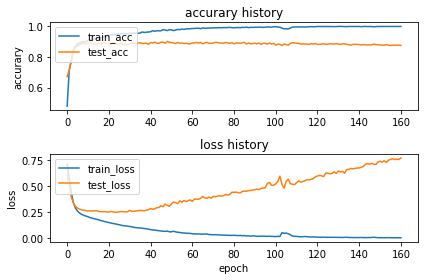

In [33]:
print('on training data:')
for name, value in zip(network.metrics_names, network_result_train):
    print(' '*3, name, ':', value)

print('\non test data:')
for name, value in zip(network.metrics_names, network_result_test):
    print(' '*3, name, ':', value)

print('\n')

# training & testing accuracy
plt.subplot(211)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("accurary")
plt.title("accurary history")
plt.legend(['train_acc','test_acc'], loc='upper left')

# training & testing loss
plt.subplot(212)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.title("loss history")
plt.legend(['train_loss', 'test_loss'], loc='upper left')
plt.xlabel("epoch")

plt.tight_layout()
plt.show()

## XGBoost

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_boost, test_size=0.25, random_state=42)
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)

print('XGBoost')
print('on training data:')
pred = xgbc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = xgbc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

XGBoost
on training data:
   accuracy: 0.939249553305539
   precision: 0.8716744913928013
   recall: 0.9653379549393414
   f1-score: 0.9161184210526315

on test data:
   accuracy: 0.8946428571428572
   precision: 0.8162393162393162
   recall: 0.9227053140096618
   f1-score: 0.8662131519274378


## CatBoost

In [35]:
cbc = CatBoostClassifier()
cbc.fit(x_train, y_train)

Learning rate set to 0.012854
0:	learn: 0.6750809	total: 1.73ms	remaining: 1.73s
1:	learn: 0.6601550	total: 3.3ms	remaining: 1.65s
2:	learn: 0.6425870	total: 4.76ms	remaining: 1.58s
3:	learn: 0.6207201	total: 6.34ms	remaining: 1.58s
4:	learn: 0.6080047	total: 8.03ms	remaining: 1.6s
5:	learn: 0.5920492	total: 9.76ms	remaining: 1.62s
6:	learn: 0.5805888	total: 11.5ms	remaining: 1.63s
7:	learn: 0.5712372	total: 13.1ms	remaining: 1.62s
8:	learn: 0.5553074	total: 14.5ms	remaining: 1.6s
9:	learn: 0.5439792	total: 16.2ms	remaining: 1.61s
10:	learn: 0.5324516	total: 17.9ms	remaining: 1.61s
11:	learn: 0.5193803	total: 19.6ms	remaining: 1.61s
12:	learn: 0.5088689	total: 21.3ms	remaining: 1.61s
13:	learn: 0.4993233	total: 22.9ms	remaining: 1.61s
14:	learn: 0.4906423	total: 24.6ms	remaining: 1.62s
15:	learn: 0.4817764	total: 26.4ms	remaining: 1.62s
16:	learn: 0.4703680	total: 28.1ms	remaining: 1.62s
17:	learn: 0.4647532	total: 29.7ms	remaining: 1.62s
18:	learn: 0.4540301	total: 31.5ms	remaining: 1

In [36]:
print('CatBoost')
print('on training data:')
pred = cbc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = cbc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

CatBoost
on training data:
   accuracy: 0.9934484812388327
   precision: 0.9845890410958904
   recall: 0.9965337954939342
   f1-score: 0.9905254091300603

on test data:
   accuracy: 0.9160714285714285
   precision: 0.8418803418803419
   recall: 0.9516908212560387
   f1-score: 0.8934240362811792


## KNN

100%|██████████| 100/100 [00:06<00:00, 15.35it/s]


Text(0, 0.5, 'Mean Error')

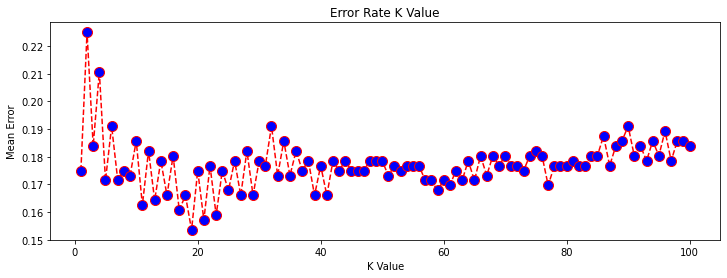

In [37]:
range_to = 101
error = []
for i in tqdm(range(1, range_to)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 4))
plt.plot(range(1, range_to), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [38]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(x_train, y_train)

print('KNN')
print('on training data:')
pred = knn.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = knn.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

KNN
on training data:
   accuracy: 0.8695652173913043
   precision: 0.8509803921568627
   recall: 0.7521663778162911
   f1-score: 0.7985280588776448

on test data:
   accuracy: 0.8464285714285714
   precision: 0.8418079096045198
   recall: 0.7198067632850241
   f1-score: 0.7760416666666666


## DecisionTree

Income:       0.0197
NumWebPurchases: 0.0511
NumCatalogPurchases: 0.7338
NumStorePurchases: 0.1474
NumWebVisitsMonth: 0.048


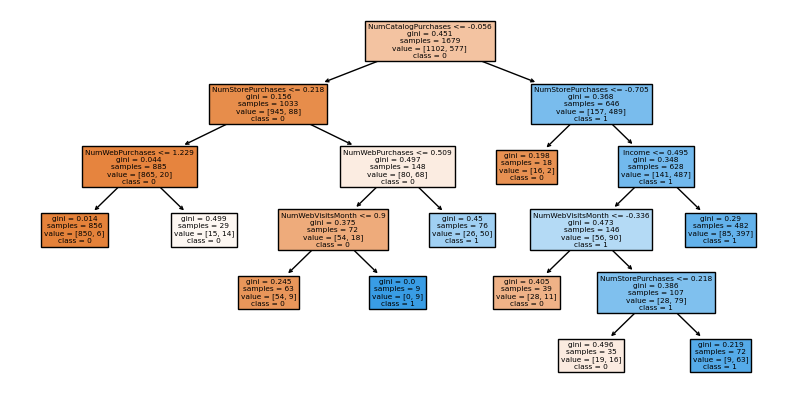

In [39]:
dtc = DecisionTreeClassifier(criterion = "gini", max_depth=10, 
                             min_samples_split=50, min_samples_leaf=5, 
                             max_leaf_nodes=10, random_state=48)
feature_names = df.columns.tolist()
dtc.fit(x_train, y_train)
for i, j in zip(feature_names, dtc.feature_importances_):
    if j > 0: print((i + ":").ljust(13), round(j, 4))

plt.figure(figsize = (10, 5), dpi = 100)
plot_tree(dtc, feature_names=feature_names, class_names=['0','1'], filled=True)
plt.show()

In [40]:
print('Decision Tree')
print('on training data:')
pred = dtc.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = dtc.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

Decision Tree
on training data:
   accuracy: 0.8939845145920191
   precision: 0.812206572769953
   recall: 0.8994800693240901
   f1-score: 0.8536184210526315

on test data:
   accuracy: 0.8446428571428571
   precision: 0.7564102564102564
   recall: 0.855072463768116
   f1-score: 0.802721088435374


## RandomForest

In [41]:
clf = RandomForestClassifier(random_state = 6)
clf.fit(x_train, y_train)

print('Random Forest')
print('on training data:')
pred = clf.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = clf.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

Random Forest
on training data:
   accuracy: 1.0
   precision: 1.0
   recall: 1.0
   f1-score: 1.0

on test data:
   accuracy: 0.9160714285714285
   precision: 0.8478260869565217
   recall: 0.9420289855072463
   f1-score: 0.8924485125858124


## SVM

In [42]:
svm = SVC()
svm.fit(x_train, y_train)

print('SVM')
print('on training data:')
pred = svm.predict(x_train)
print(f"{' '*3}accuracy: {accuracy_score(y_train, pred)}")
print(f"{' '*3}precision: {precision_score(y_train, pred)}")
print(f"{' '*3}recall: {recall_score(y_train, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_train, pred)}")

print('\non test data:')
pred = svm.predict(x_test)
print(f"{' '*3}accuracy: {accuracy_score(y_test, pred)}")
print(f"{' '*3}precision: {precision_score(y_test, pred)}")
print(f"{' '*3}recall: {recall_score(y_test, pred)}")
print(f"{' '*3}f1-score: {f1_score(y_test, pred)}")

SVM
on training data:
   accuracy: 0.9267421083978559
   precision: 0.8758278145695364
   recall: 0.9168110918544194
   f1-score: 0.8958509737510584

on test data:
   accuracy: 0.8803571428571428
   precision: 0.8181818181818182
   recall: 0.8695652173913043
   f1-score: 0.8430913348946135


# overall results